In [255]:
import pandas as pd

df = pd.read_csv('../../data/Advanced/pl_final.csv')

In [256]:
df = df.sort_values('date')

df['home_xG_rolling'] = (
    df.groupby('home_team')['xG'].transform(lambda s: s.shift().rolling(5, min_periods=1).mean())
)

df['away_xG_rolling'] = (
    df.groupby('away_team')['xG.1'].transform(lambda s: s.shift().rolling(5, min_periods=1).mean())
)

df['xG_diff_rolling'] = df['home_xG_rolling'] - df['away_xG_rolling']

df['elo_diff'] = df['home_elo_before'] - df['away_elo_before']

df['goals_diff_rolling'] = df['home_goals_scored_rolling'] - df['away_goals_scored_rolling']
df['conceded_diff_rolling'] = df['home_goals_conceded_rolling'] - df['away_goals_conceded_rolling']

In [257]:
df.dropna(inplace=True, axis=0)
df.columns

Index(['date', 'home_team', 'away_team', 'result', 'odds_home_win',
       'odds_draw', 'odds_away_win', 'home_goals_scored_rolling',
       'home_goals_conceded_rolling', 'home_shots_rolling',
       'home_shots_on_target_rolling', 'home_fouls_rolling',
       'home_corners_rolling', 'home_yellow_cards_rolling',
       'home_red_cards_rolling', 'away_goals_scored_rolling',
       'away_goals_conceded_rolling', 'away_shots_rolling',
       'away_shots_on_target_rolling', 'away_fouls_rolling',
       'away_corners_rolling', 'away_yellow_cards_rolling',
       'away_red_cards_rolling', 'home_elo_before', 'away_elo_before',
       'prob_home', 'prob_draw', 'prob_away', 'xG', 'xG.1', 'home_xG_rolling',
       'away_xG_rolling', 'xG_diff_rolling', 'elo_diff', 'goals_diff_rolling',
       'conceded_diff_rolling'],
      dtype='object')

In [258]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, brier_score_loss, confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns


In [259]:
df = df.sort_values('date')

In [260]:
X = df.drop(columns=['result', 'date', 'xG', 'xG.1', 'home_red_cards_rolling', 'away_red_cards_rolling', 'home_team', 'away_team'])
y = df['result']

In [261]:
tscv = TimeSeriesSplit(n_splits=5)
rf_importances = []

In [262]:
def multiclass_brier_score(y_true, y_prob):
    """
    Computes the multiclass Brier score (the mean squared error between
    one-hot labels and predicted probabilities).
    """
    n_classes = y_prob.shape[1]
    y_true_onehot = np.eye(n_classes)[y_true]  # One-hot encode labels
    return np.mean(np.sum((y_prob - y_true_onehot)**2, axis=1)) / n_classes

def evaluate_model(model, X_train, X_test, y_train, y_test, name="Model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    # --- Metrics ---
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='weighted', zero_division=0)
    rec = recall_score(y_test, preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, preds, average='weighted', zero_division=0)
    ll = log_loss(y_test, probs)

    # Correct multiclass Brier score
    brier = multiclass_brier_score(y_test.to_numpy(), probs)

    metrics = {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "log_loss": ll,
            "brier": brier,
            "confusion_matrix": cm
        }

    print(f"\n=== {name} ===")
    print(metrics)

    # --- Classification Report ---
    print("\nClassification Report:")
    print(classification_report(
        y_test, preds, 
        target_names=["Draw", "Away", "Home"],
        zero_division=0
    ))

    # # --- Confusion Matrix ---
    # cm = confusion_matrix(y_test, preds)
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(
    #     cm, annot=True, fmt='d',
    #     xticklabels=["Draw", "Away", "Home"],
    #     yticklabels=["Draw", "Away", "Home"]
    # )
    # plt.title(f"Confusion Matrix: {name}")
    # plt.xlabel("Predicted")
    # plt.ylabel("True")
    # plt.show()
    return metrics

In [263]:
results = {
    "RandomForest": [],
    "XGBoost": [],
    "CatBoost": []
}

rf_importances = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\n================ FOLD {fold+1} ================")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # --- 1. Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=1500,
        max_depth=12,
        min_samples_split=4,
        random_state=42
    )

    m_rf = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")
    results["RandomForest"].append(m_rf)
    rf_importances.append(rf.feature_importances_)
    
    # --- 2. XGBoost ---
    xgb = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        n_estimators=1500,
        learning_rate=0.03,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        tree_method='hist'
    )
    m_xgb = evaluate_model(xgb, X_train, X_test, y_train, y_test, "XGBoost")
    results["XGBoost"].append(m_xgb)

    # --- 3. CatBoost ---
    cat = CatBoostClassifier(
        loss_function='MultiClass',
        depth=7,
        iterations=1500,
        learning_rate=0.03,
        verbose=False
    )
    m_cat = evaluate_model(cat, X_train, X_test, y_train, y_test, "CatBoost")
    results["CatBoost"].append(m_cat)



================ FOLD 1 ================

=== Random Forest ===
{'accuracy': 0.5243445692883895, 'precision': 0.43066133775733356, 'recall': 0.5243445692883895, 'f1': 0.47281917579974697, 'log_loss': 1.0310052956820628, 'brier': np.float64(0.2034419491146989), 'confusion_matrix': array([[  2,  24,  44],
       [  1,  59,  49],
       [  0,  18, 125]])}

Classification Report:
              precision    recall  f1-score   support

        Draw       0.00      0.00      0.00        58
        Away       0.50      0.63      0.56        84
        Home       0.58      0.70      0.64       125

    accuracy                           0.52       267
   macro avg       0.36      0.44      0.40       267
weighted avg       0.43      0.52      0.47       267


=== XGBoost ===
{'accuracy': 0.5056179775280899, 'precision': 0.4805776533535869, 'recall': 0.5056179775280899, 'f1': 0.4845187953153019, 'log_loss': 1.5681064627880845, 'brier': np.float64(0.2579898466419283), 'confusion_matrix': array([

In [264]:
import pandas as pd

def summarize_results(results):
    summary = {}
    for model_name, folds in results.items():
        df = pd.DataFrame(folds)
        avg = df.mean(numeric_only=True)
        summary[model_name] = avg
        print(f"\n====== AVERAGE RESULTS: {model_name} ======")
        print(avg)
    return summary

summary = summarize_results(results)



====== AVERAGE RESULTS: RandomForest ======
accuracy     0.548315
precision    0.477109
recall       0.548315
f1           0.487588
log_loss     0.984529
brier        0.194624
dtype: float64

====== AVERAGE RESULTS: XGBoost ======
accuracy     0.510861
precision    0.473618
recall       0.510861
f1           0.480215
log_loss     1.398435
brier        0.241120
dtype: float64

====== AVERAGE RESULTS: CatBoost ======
accuracy     0.536330
precision    0.469575
recall       0.536330
f1           0.484861
log_loss     1.060409
brier        0.206877
dtype: float64


In [265]:
def average_confusion_matrix(model_name):
    cms = [r["confusion_matrix"] for r in results[model_name]]
    return sum(cms) / len(cms)

avg_cm_rf = average_confusion_matrix("RandomForest")
avg_cm_xgb = average_confusion_matrix("XGBoost")
avg_cm_cat = average_confusion_matrix("CatBoost")


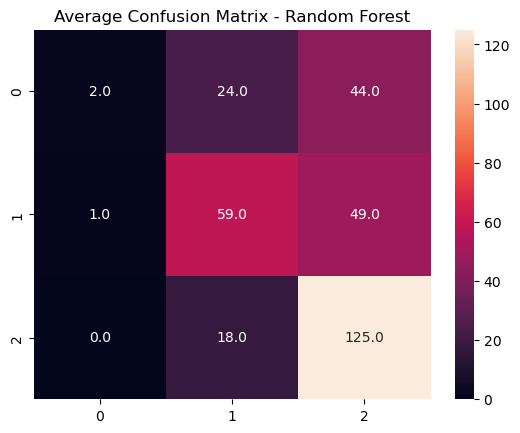

In [266]:
sns.heatmap(avg_cm_rf, annot=True, fmt=".1f")
plt.title("Average Confusion Matrix - Random Forest")
plt.show()

In [267]:
# Average across folds
rf_importances = np.array(rf_importances)
avg_importances = rf_importances.mean(axis=0)

# Put in a DataFrame for readability
fi_df = pd.DataFrame({
    "feature": X.columns,
    "importance": avg_importances
}).sort_values("importance", ascending=False)

In [268]:
fi_df.tail(60)

,feature,importance
19,prob_home,0.061914
21,prob_away,0.061897
2,odds_away_win,0.048050
25,elo_diff,0.046951
0,odds_home_win,0.046259
17,home_elo_before,0.042703
18,away_elo_before,0.039647
20,prob_draw,0.039036
24,xG_diff_rolling,0.038563
12,away_shots_rolling,0.037858


In [269]:
home_baseline_acc = (y_test == 2).mean()
print(f"Baseline (Always Home Win): {home_baseline_acc:.2f}")


Baseline (Always Home Win): 0.47


In [270]:
most_common = y_train.value_counts().idxmax()
print(most_common)
freq_baseline_acc = (y_test == most_common).mean()
print(f"Baseline (Most Frequent Class = {most_common}): {freq_baseline_acc:.2f}")


2
Baseline (Most Frequent Class = 2): 0.47
